# Recurrent neural network for sequence modeling

Human language follows a sequence. We need a neural network that can model such sequences. RNN can take word order in account and previous context while working on a particular time step, $t$. 

### RNN for sequences
- Speech Recognition
- Language model
- Image captioning
- Visual question answering 
- Poetry generation
- Generated C code

### RNN **Architecture** for sentence classification




## Features for Recurrent networks
We can use hadcrafted features for training RNNs. In 2013, onwards standard practice is to use **embeddings** i.e. Glove, word2vec as input feature to the nework. Note that, a network has some hidden layers. Typically, it can be 2 or 3 layers deeep. Those deep layers, learn regularities in data and we feed output of the last layer for a **classification** layer. It is also known as `softmax` which produces your output class. 

In todays practice, we use **pretrained language models** for transfer learning. The intuition is giving more descriptive and rich features space to the network. Languages models are trained on billions of web data. An LM has rich syntactic, semantic and high capacity for extracting context from an input sentence. 

## Training RNNs: Backpropagation through time (BPTT)
In practice we use Truncated BPTT to make the training faster. BPTT is similar to backpropagation in neural nets except for it has to work with chain rule!

### Activation function

- sigmoid
- tanh


## Limitations of RNNs

gradient vanishes when long dependencies aries

## Handling long term dependencies

**Problem:** can’t capture long-term dependencies due to vanishing/exploding gradients during backpropagation

### Vanishing gradient problem 

- The exploding gradients problem refers to the large increase in the norm of the gradient during training.

- The vanishing gradients problem refers to the opposite behaviour, when long term components go exponentially fast to norm ￼, making it impossible for the model to learn correlation between temporally distant events.


#### Norm clipping
- Originally used by Tomas et al. to get state of the art results in LM.
- Modified here to be more theoretically justified.
- Threshold — introduce an additional hyper-parameter.

### Long short term memory network

Introduces a memory celle to mitigate long term dependency issues. It has 3 gates to control information flow.

### Word embeddings

- Glove
- word2vec

### Pretained Language Models

LM: predicting the next word in a sequence. Pretrained models is used for  solving downstream task.



---



# Classification task in NLP

## A pipeline for classification task using RNN
1. Import libraries
2. Import dataset

### Import libraries (we're using tensoflow)

In [ ]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()


# Import `matplotlib` and create a helper function to plot graphs:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

### Load the dataset (train and test set)

In [ ]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteD0LPJG/imdb_reviews-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteD0LPJG/imdb_reviews-test.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteD0LPJG/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

## You must inspect your data before building a classifier model

In [ ]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


## We now creating batches for model training. This is required for `minibatch gradient descent`. 

In [ ]:
BUFFER_SIZE = 5000
BATCH_SIZE = 128

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"What on earth has become of our dear Ramu? Is this the same man who made Sarkar, Satya, and Comapny? I refuse to believe so. If AAG was Ramu's most ambitious project, he has clearly jumped off the high cliff he has ascended by giving the industry some of the greatest works of all times. This movie is made to fall like a brick. I was cringing to leave the theater, but I was forced to sit because I wouldn't have been able to take my car out of the parking lot before others also left. Else, nothing would have made me sit beyond interval.<br /><br />This movie is nowhere close to Sholay. It doesn't even come near it within a mile. I believe Ramu surely loves The Godfather more than Sholay, since Sarkar was a classic piece of work. I read Ramu's interview a couple of days back, in which the interviewer said that Ramu doesn't sleep for more than 4 hours a day, that too not at a stretch. I completely agree with this now, as his lack of sleep has probably taken its toll on the movie

### Text encoder: next step is vectorizing your input sentences. Model can't work with `string`. You vectorize them i.e. matrices with numeric values.

We use tf text `TextVectorization` layer and pass our data for required processing. This part involves creating a `vocabulary` with numeric indices. We replace eash token with corresponding index. 

**What happens when input token is missing in the vocabulary?**

In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

# take a look at vocabs
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [ ]:
# let's look at some example encoded sentences

encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 49,  21, 721, ...,   0,   0,   0],
       [  1,   1,   1, ...,   0,   0,   0],
       [  9,   7,  86, ...,   0,   0,   0]])

## Do we notice some  padded `0` at the end of each sentence? Why we are inserting some tailing zeros? 

We may want to preprocess input tokens i.e. remove punctuation, lower case, stemming etc.

In [ ]:
# a bit of preprocessing hels
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"What on earth has become of our dear Ramu? Is this the same man who made Sarkar, Satya, and Comapny? I refuse to believe so. If AAG was Ramu's most ambitious project, he has clearly jumped off the high cliff he has ascended by giving the industry some of the greatest works of all times. This movie is made to fall like a brick. I was cringing to leave the theater, but I was forced to sit because I wouldn't have been able to take my car out of the parking lot before others also left. Else, nothing would have made me sit beyond interval.<br /><br />This movie is nowhere close to Sholay. It doesn't even come near it within a mile. I believe Ramu surely loves The Godfather more than Sholay, since Sarkar was a classic piece of work. I read Ramu's interview a couple of days back, in which the interviewer said that Ramu doesn't sleep for more than 4 hours a day, that too not at a stretch. I completely agree with this now, as his lack of sleep has probably taken its toll on the mov

# Now we can create a model 

What is a `model`? A model could be anything that fits your data. RNN itself is a `network`. We can design RNN's depth and wide, that is called `architecture` i.e. number of neurons, layers, weight sharing mechanism. We use `stochastic gradient descent (SGD)` algorithm for training the network.

![image](https://drive.google.com/uc?id=1aAhUKa20nxPYHOk7dj6rff-vq3OH9F7i)

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=300,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding_3 (Embedding)     (None, None, 300)         300000    
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              186880    
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 495,201
Trainable params: 495,201
Non-tr

### Handling variable length sequences. Embedding takes care of that and output a fixed length sequence.

In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

[-0.00833915]


In [ ]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

[-0.00833915]


### Training requires an `optmizer`, a `loss function` and evaluation `metrics`. 

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-5),
              metrics=['accuracy'])

## Train the model

In [ ]:
history = model.fit(train_dataset, epochs=5,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/5
196/196 [==============================] - 631s 3s/step - loss: 0.6870 - accuracy: 0.5050 - val_loss: 0.6388 - val_accuracy: 0.5953
Epoch 2/5
196/196 [==============================] - 625s 3s/step - loss: 0.5157 - accuracy: 0.7112 - val_loss: 0.4457 - val_accuracy: 0.7781
Epoch 3/5
196/196 [==============================] - 627s 3s/step - loss: 0.4170 - accuracy: 0.8105 - val_loss: 0.4065 - val_accuracy: 0.8148
Epoch 4/5
196/196 [==============================] - 625s 3s/step - loss: 0.3782 - accuracy: 0.8377 - val_loss: 0.3710 - val_accuracy: 0.8339
Epoch 5/5
196/196 [==============================] - 629s 3s/step - loss: 0.3747 - accuracy: 0.8325 - val_loss: 0.3608 - val_accuracy: 0.8336


In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

196/196 [==============================] - 154s 787ms/step - loss: 0.3620 - accuracy: 0.8290
Test Loss: 0.3620011806488037
Test Accuracy: 0.8289600014686584


## Trraining curve is like an obsession. It's an art! We will soon fall in love with it! 

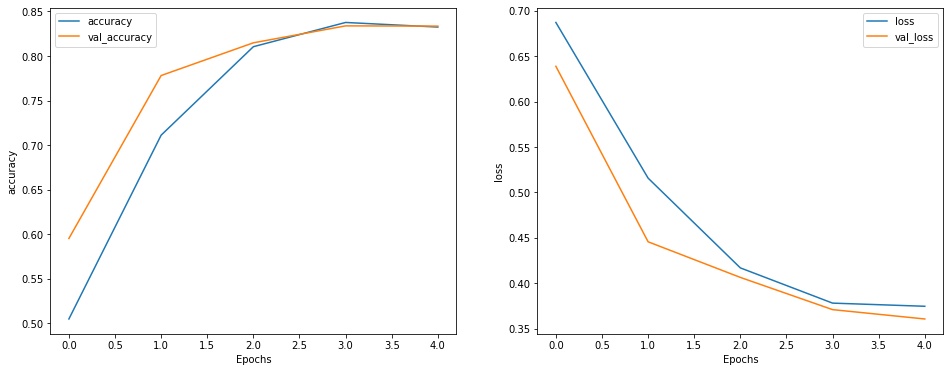

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

# It seems neural network are so easy to train? What can I do to build something new and cool?

There are mulitple areas that you can contribute:
1. Introducing a new task and evaluating existing models on them (you are now contributing something similar with your work).
2. Train models that can learn fast and maintain robustness (our group has some work along this line. Rabiul works on *Rui* works on domain robustness).
3. Bridging the language gap --> NLP for SEA languages (most of the nlp tools are developed for English. *Rabiul* is working on multilingual nlp).
4. Develop novel architecture to address your problem of interest (incoroporate hierarchical structure in RNNs. how about solving problems such as rumor propagation? *Shaun* works on adversarial attacks).
5. Neural networks has limited reasoning capacity. They are extremely good function approximator! They can fit your data well (it's hard to explain behavior of a neural net. *Mingshaan* works on explainabilty).
6. Design tools that can help solve some real world problems (deploy a LSTM based hate classifier for public use. *Zhiqiang* works on generative modeling.).